In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler
import matplotlib.pyplot as plt
import cooltools.lib.plotting as clp
import tqdm
import glob

from scipy import stats

plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

/tmp/ipykernel_2259750/1803924016.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## 对比 bonev2017 nagano 2017 和 CHARM 的Hi-C 热图

In [2]:
metadata = pd.read_csv("../data/metadata/metadata.tsv", sep="\t")
metadata["plate"] = metadata["cellname"].str[:-3]
cellnames = metadata["cellname"].values


In [3]:
genome_coord = "chr2:10000000-20000000"
mats = []
for cellname in tqdm.tqdm(cellnames): 
    clr = cooler.Cooler(f"/zliu_ssd/CHARM/CHARM_mesc/data/cools/{cellname}.mcool::/resolutions/20000")
    mats.append(clr.matrix(balance=False).fetch(genome_coord))

mat_charm = np.nanmean(mats, axis=0)
mat_charm = mat_charm / mat_charm.sum() * 1e6

100%|██████████| 803/803 [00:16<00:00, 49.14it/s]


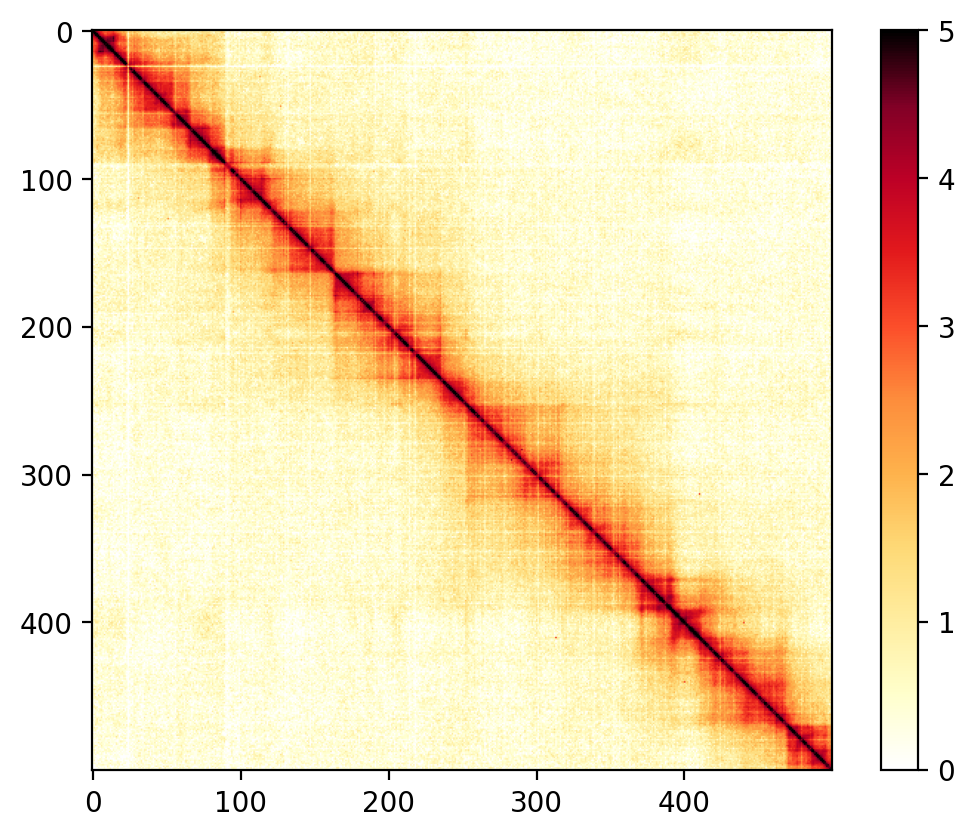

In [4]:
plt.imshow(np.log1p(mat_charm), cmap="fall",vmin=0,vmax=5)
plt.colorbar()

In [5]:
nagano_clrs = glob.glob("/sharec/zliu/archieve/else/research/publicData/tanay_cellcycle_alldata_2/result/cools/*.mcool")
# sample same number of cells as CHARM
np.random.seed(42)
nagano_clrs = np.random.choice(nagano_clrs, len(cellnames), replace=False)
nagano_clrs = [cooler.Cooler(x + "::/resolutions/20000") for x in nagano_clrs]
mats = [clr.matrix(balance=False).fetch(genome_coord) for clr in nagano_clrs]
mat_nagano = np.sum(mats, axis=0)
mat_nagano = mat_nagano / np.sum(mat_nagano) * 1e6

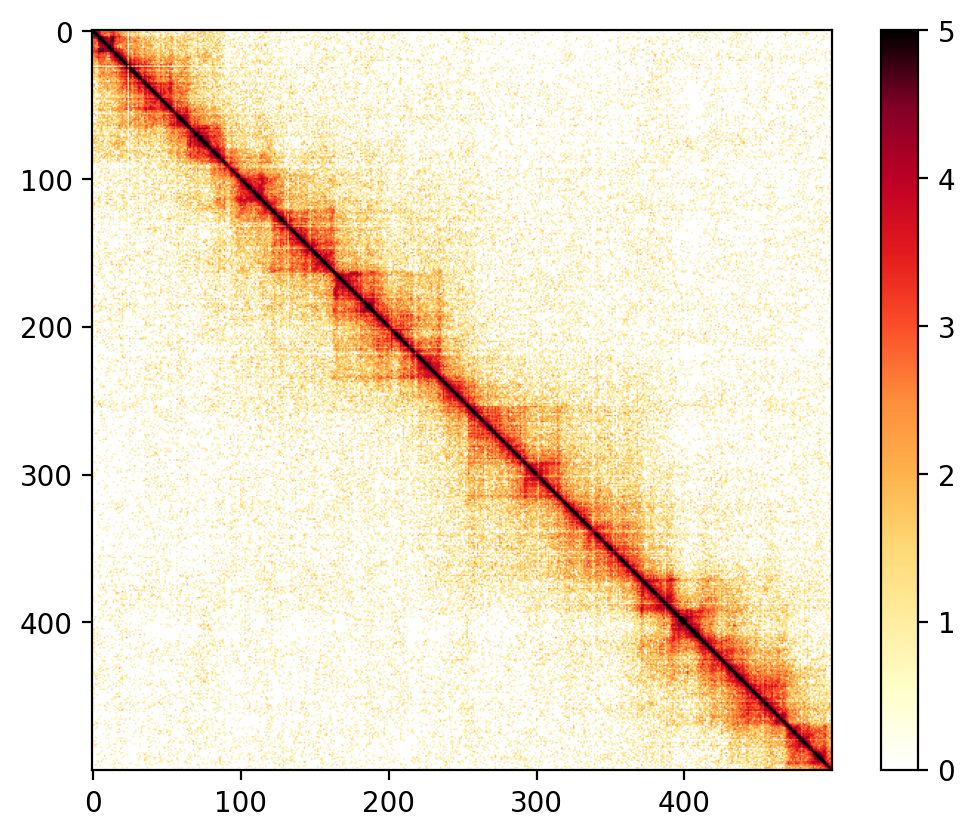

In [6]:
plt.imshow(np.log1p(mat_nagano), cmap="fall",vmin=0, vmax=5)
plt.colorbar()

In [7]:
bonev_ES_clr = cooler.Cooler("/sharec/zliu/archieve/else/research/publicData/Bonev2017/processedData/processed/mcools/ES.balanced.mcool::/resolutions/20000")

In [8]:
bonev_ES_clr = cooler.Cooler("/sharec/zliu/archieve/else/research/publicData/Bonev2017/processedData/processed/mcools/ES.balanced.mcool::/resolutions/20000")
mat_bonev = bonev_ES_clr.matrix(balance=False).fetch(genome_coord)
mat_bonev = mat_bonev/mat_bonev.sum()*1e6

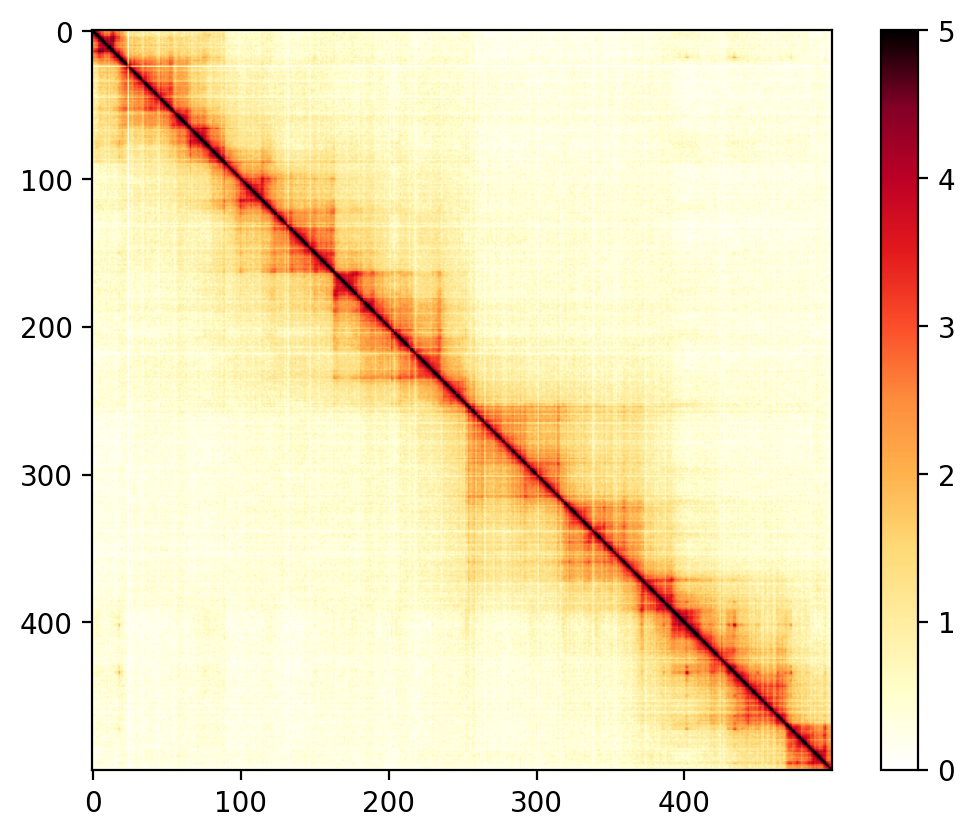

In [9]:
plt.imshow(np.log1p(mat_bonev), cmap="fall",vmin=0, vmax=5)
plt.colorbar()

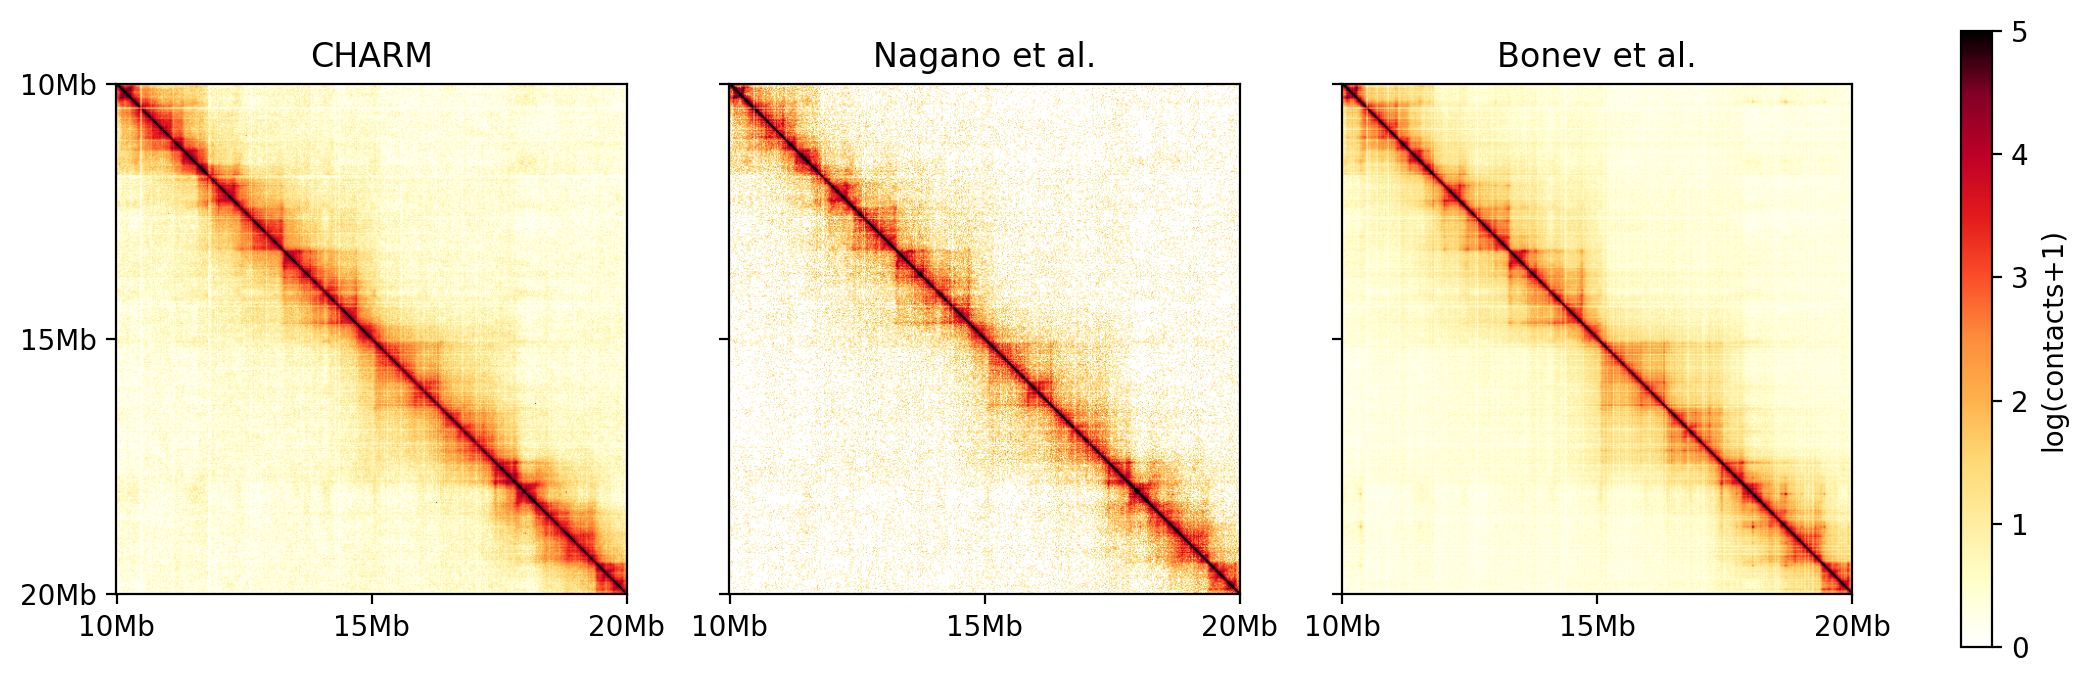

In [10]:
%config InlineBackend.figure_format = 'retina'

# combine all three plots
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
axs[0].imshow(np.log1p(mat_charm), cmap="fall",vmin=0, vmax=5)
axs[0].set_title("CHARM")
axs[1].imshow(np.log1p(mat_nagano), cmap="fall",vmin=0, vmax=5)
axs[1].set_title("Nagano et al.")
axs[2].imshow(np.log1p(mat_bonev), cmap="fall",vmin=0, vmax=5)
axs[2].set_title("Bonev et al.")

plt.colorbar(axs[0].imshow(np.log1p(mat_charm), cmap="fall",vmin=0, vmax=5), ax=axs, orientation="vertical", label="log(contacts+1)")

plt.yticks([0,250,500], ["10Mb", "15Mb", "20Mb"])
plt.xticks([0,250,500], ["10Mb", "15Mb", "20Mb"])

# save pdf
plt.savefig("figures/hicheatmap_comparison.pdf")


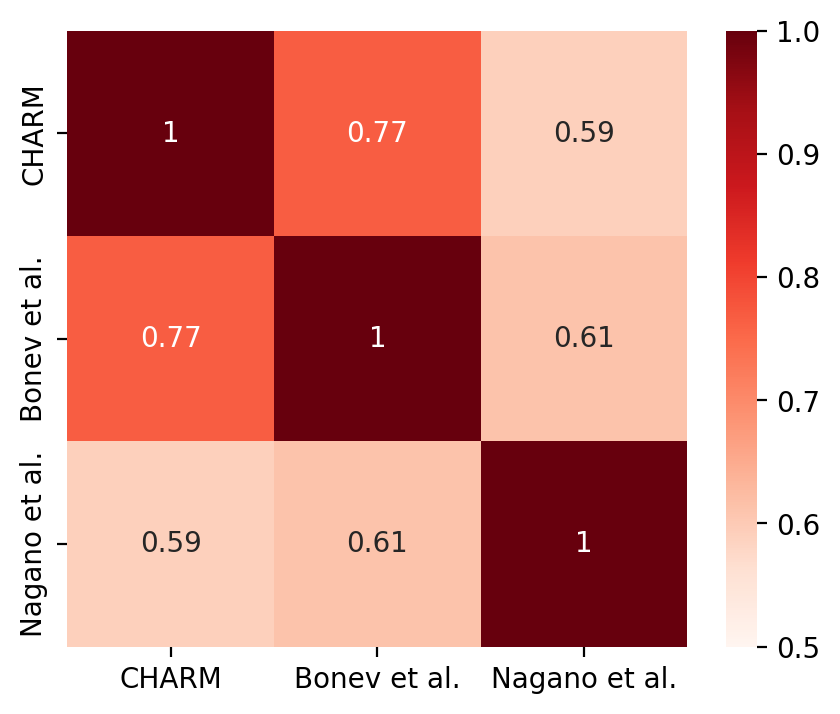

In [11]:
# correlation matrix between the three datasets
data = np.array([mat_charm.flatten(),  mat_bonev.flatten(), mat_nagano.flatten()])
corr = np.array([[stats.spearmanr(data[i], data[j])[0] for i in range(3)] for j in range(3)])

fig = plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, xticklabels=["CHARM", "Bonev et al.", "Nagano et al."], yticklabels=["CHARM", "Bonev et al.", "Nagano et al."], cmap="Reds", vmin=0.5, vmax=1)

# save pdf
plt.savefig("figures/hicheatmap_coormat_spearman.pdf")

In [12]:
# comapre ab compartment 
charm_compartment = pd.read_csv("../data/bulk/processed/compartment/mesc.compartment.100k.cis.vecs.tsv", sep="\t")
bonev_compartment = pd.read_csv("/sharec/zliu/archieve/else/research/publicData/Bonev2017/processedData/processed/compartment/ES.compartment.100k.cis.vecs.tsv", sep="\t")

In [13]:
compartment_merge = charm_compartment[["chrom","start","end","E1"]].merge(bonev_compartment[["chrom","start","end","E1"]], on=["chrom","start","end"], suffixes=("_charm", "_bonev")).dropna()

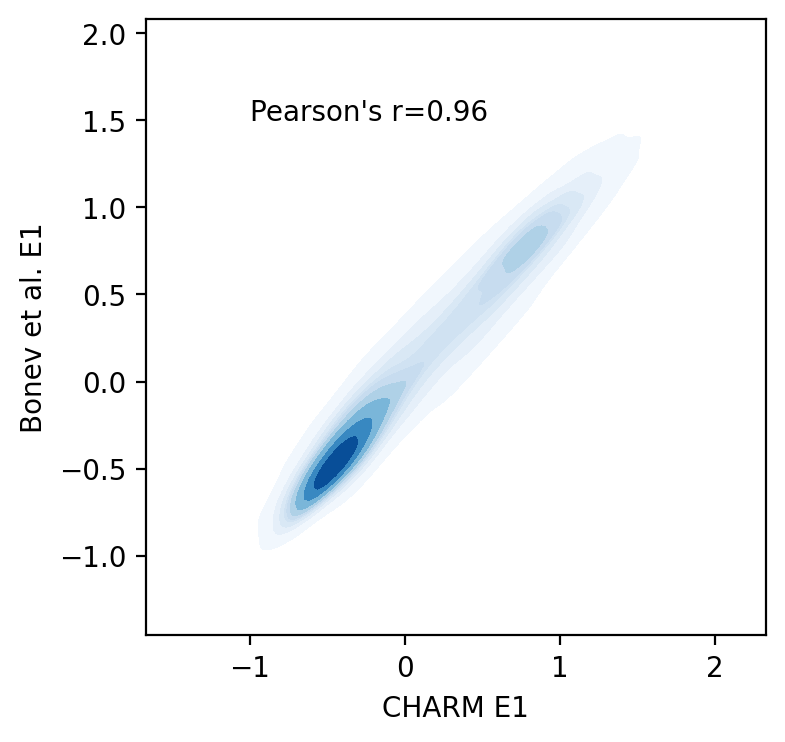

In [14]:
%config InlineBackend.figure_format = 'retina'
# scatter plot 
fig = plt.figure(figsize=(4,4))
# plt.scatter(compartment_merge["E1_charm"], compartment_merge["E1_bonev"], s=1)
# density plot
sns.kdeplot(compartment_merge, x="E1_charm", y="E1_bonev", fill=True, cmap="Blues", levels=10)
plt.xlabel("CHARM E1")
plt.ylabel("Bonev et al. E1")
# text pearson r
r, p = stats.pearsonr(compartment_merge["E1_charm"], compartment_merge["E1_bonev"])
plt.text(-1, 1.5, f"Pearson's r={r:.2f}")
plt.savefig("figures/compartment_scatter.pdf")

## ATAC / H3K27me3

In [15]:
def  _read_coverage(file_path):
    coverage = pd.read_csv(file_path, sep="\t", header=None)
    coverage.columns = ["chrom", "start", "end", "features", "bases", "length", "fraction"]
    coverage["features"] = coverage["features"] / coverage["features"].sum() * 1e6
    return coverage

charm_atac = _read_coverage("./epi_scatter/CHARM_mesc.atac.bed")
charm_atac["type"] = "CHARM"
dnase_rep1 = _read_coverage("./epi_scatter/ENCFF754ILF_DnaseI_rep1.bed")
dnase_rep1["type"] = "DnaseI"

#dnase_rep2 = _read_coverage("./epi_scatter/ENCFF785XJZ_DnaseI_rep2.bed")

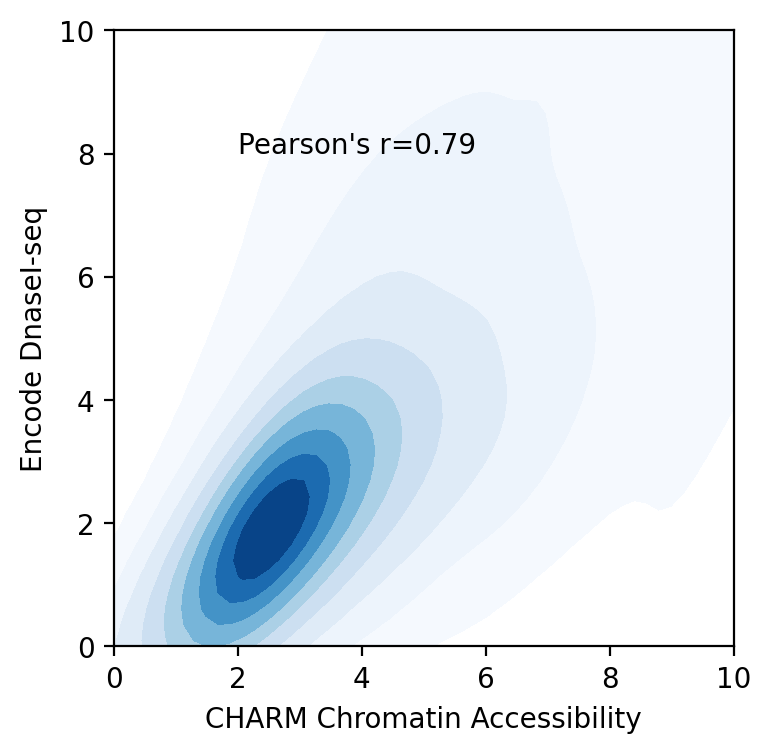

In [16]:
%config InlineBackend.figure_format = 'retina'
# scatter plot 
fig = plt.figure(figsize=(4,4))

pdata = pd.concat([charm_atac, dnase_rep1])
pdata.query('features > 0 & features < 50', inplace=True)
pdata = pdata[["features","type"]].pivot(columns="type").dropna()
pdata.columns = ["CHARM", "DnaseI"]

# set seed
np.random.seed(42)
sns.kdeplot(pdata.sample(4000), x="CHARM", y="DnaseI", fill=True, cmap="Blues", levels=10)
pearsonr = stats.pearsonr(pdata["CHARM"], pdata["DnaseI"])
plt.text(2, 8, f"Pearson's r={pearsonr[0]:.2f}")

plt.ylim(0, 10)
plt.xlim(0, 10)

plt.xlabel("CHARM Chromatin Accessibility")
plt.ylabel("Encode DnaseI-seq")

plt.savefig("figures/ATAC_scatter.pdf")

In [17]:

charm_ct = _read_coverage("./epi_scatter/CHARM_mesc.ct.bed")
charm_ct["type"] = "CHARM"
h3k27me3_rep1 = _read_coverage("./epi_scatter/ENCFF481UTW_H3K27me3_rep1.bed")
h3k27me3_rep1["type"] = "H3K27me3"
h3k27me3_rep2 = _read_coverage("./epi_scatter/ENCFF513YXS_H3K27me3_rep2.bed")

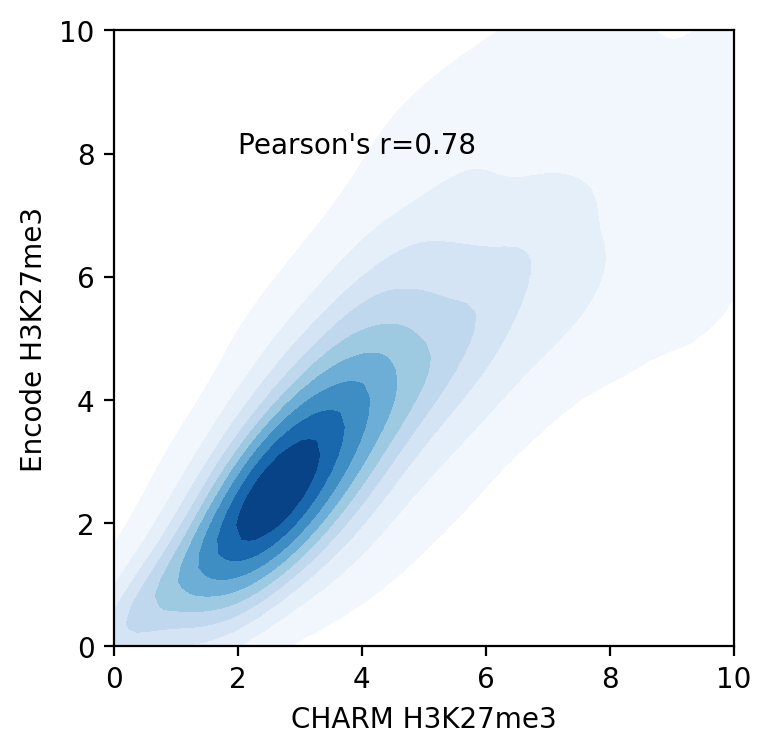

In [18]:
%config InlineBackend.figure_format = 'retina'
pdata = pd.concat([charm_ct, h3k27me3_rep1])
pdata.query('features > 0 & features < 50', inplace=True)
pdata = pdata[["features","type"]].pivot(columns="type").dropna()
pdata.columns = ["CHARM", "H3K27me3"]

fig = plt.figure(figsize=(4,4))
# set seed
np.random.seed(42)
sns.kdeplot(pdata.sample(4000), x="CHARM", y="H3K27me3", fill=True, cmap="Blues", levels=10)
pearsonr = stats.pearsonr(pdata["CHARM"], pdata["H3K27me3"])
plt.text(2, 8, f"Pearson's r={pearsonr[0]:.2f}")

plt.ylim(0, 10)
plt.xlim(0, 10)

plt.xlabel("CHARM H3K27me3")
plt.ylabel("Encode H3K27me3")

plt.savefig("figures/CT_scatter.pdf")


# RNA

In [19]:
pdata = pd.read_table("./compareRNA/rna_compare_data.tsv.gz")
pdata.head()

gene   rna_dpt  rna_charm
0     Xkr4  1.544068   2.487138
1   Gm1992  0.477121   1.414973
2  Gm19938  0.602060   0.653213
3  Gm37381  1.732394   1.866287
4      Rp1  2.309630   2.399674

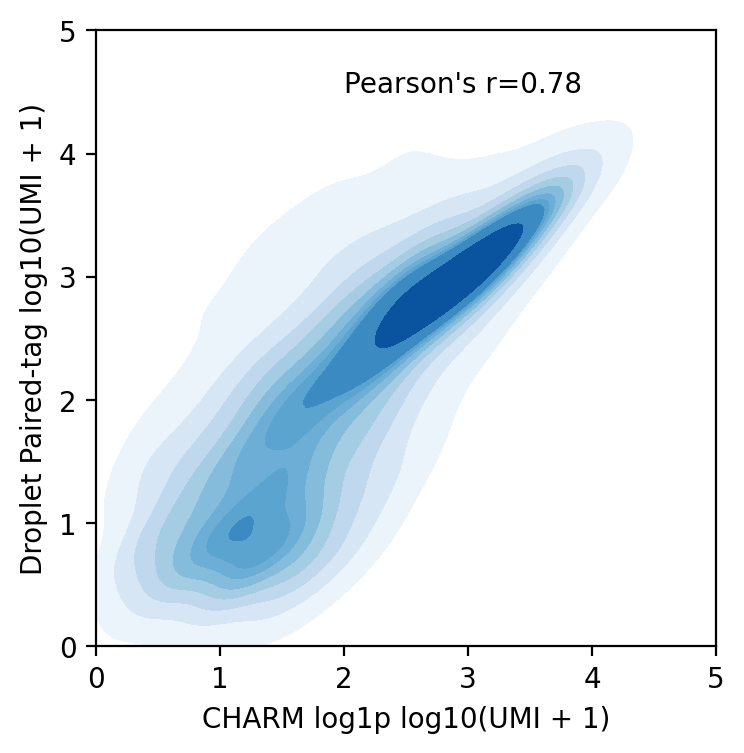

In [21]:
%config InlineBackend.figure_format = 'retina'

fig = plt.figure(figsize=(4,4))
# set seed
np.random.seed(42)
sns.kdeplot(pdata.sample(4000), x="rna_charm", y="rna_dpt", fill=True, cmap="Blues", levels=10)
pearsonr = stats.pearsonr(pdata["rna_charm"], pdata["rna_dpt"])
plt.text(2, 4.5, f"Pearson's r={pearsonr[0]:.2f}")

plt.ylim(0, 5)
plt.xlim(0, 5)

plt.xlabel("CHARM log1p log10(UMI + 1)")
plt.ylabel("Droplet Paired-tag log10(UMI + 1)")

plt.savefig("figures/RNA_scatter.pdf")
